Using device: cpu


<ipython-input-5-4c1d06ccf5bc>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device == "cuda")):


Epoch 1/15, Loss: 0.061860
Epoch 2/15, Loss: 0.053607
Epoch 3/15, Loss: 0.053537
Epoch 4/15, Loss: 0.053519
Epoch 5/15, Loss: 0.053512
Epoch 6/15, Loss: 0.053519
Epoch 7/15, Loss: 0.053486
Epoch 8/15, Loss: 0.053504
Epoch 9/15, Loss: 0.053464
Epoch 10/15, Loss: 0.053459
Epoch 11/15, Loss: 0.053479
Epoch 12/15, Loss: 0.053471
Epoch 13/15, Loss: 0.053444
Epoch 14/15, Loss: 0.053442
Epoch 15/15, Loss: 0.053434
🚀 Training completed in 196.39 seconds


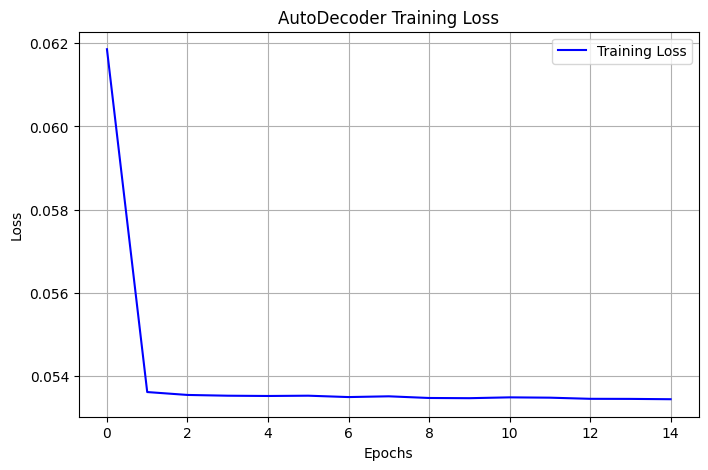

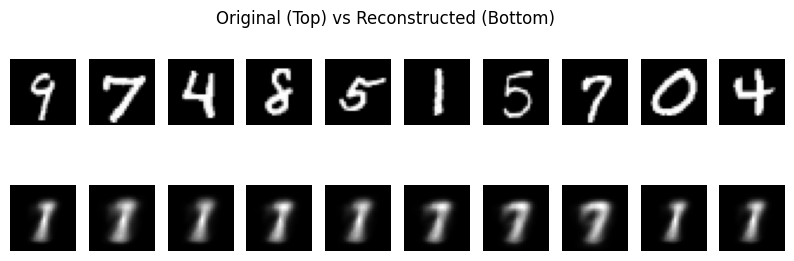

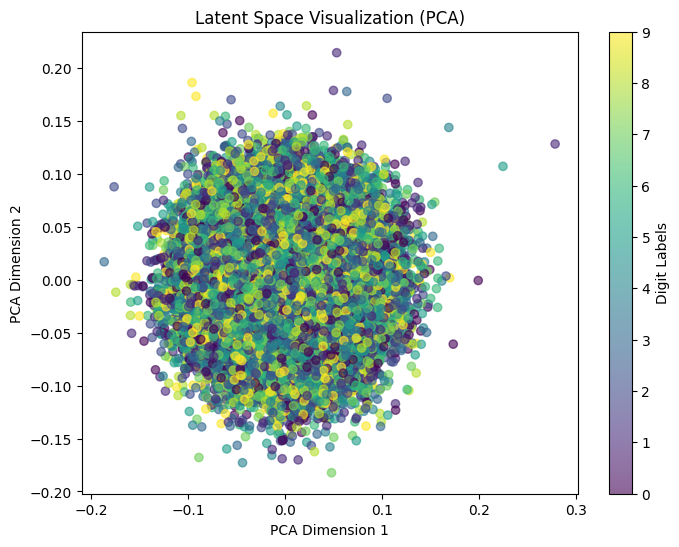

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.decomposition import PCA

# 🔥 Automatically detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print(f"Using device: {device}")

# ====== Load MNIST Data ======
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=2, pin_memory=True)

# ====== AutoDecoder Model ======
class AutoDecoder(nn.Module):
    def __init__(self, latent_dim=20, output_dim=28*28):
        super(AutoDecoder, self).__init__()
        self.latent_dim = latent_dim

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
            nn.Sigmoid()
        )

        self.latent_codes = nn.Parameter(torch.randn(len(train_dataset), latent_dim) * 0.05)

    def forward(self, indices):
        z = self.latent_codes[indices]
        return self.decoder(z)

# Initialize Model
latent_dim = 20
model = AutoDecoder(latent_dim=latent_dim).to(device)

# Optimizer and Loss
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01)
scaler = torch.cuda.amp.GradScaler() if device == "cuda" else None

# ====== Training ======
epochs = 15
loss_history = []

start_time = time.time()

for epoch in range(epochs):
    total_loss = 0

    for batch_idx, (images, indices) in enumerate(train_loader):
        images = images.view(images.size(0), -1).to(device, non_blocking=True)
        indices = indices.to(device, non_blocking=True)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=(device == "cuda")):
            outputs = model(indices)
            loss = criterion(outputs, images)

        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()

    loss_history.append(total_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.6f}")

end_time = time.time()
print(f"🚀 Training completed in {end_time - start_time:.2f} seconds")

# ====== VISUALIZATIONS ======

# 🔹 1. Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Training Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("AutoDecoder Training Loss")
plt.legend()
plt.grid(True)
plt.show()

# 🔹 2. Show Reconstructed Images
def show_images(original, reconstructed, n=10):
    fig, axes = plt.subplots(2, n, figsize=(10, 3))
    for i in range(n):
        axes[0, i].imshow(original[i].cpu().reshape(28, 28), cmap="gray")
        axes[1, i].imshow(reconstructed[i].cpu().reshape(28, 28), cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].axis("off")
    plt.suptitle("Original (Top) vs Reconstructed (Bottom)")
    plt.show()

# Test Reconstruction
indices = torch.randint(0, len(train_dataset), (10,)).to(device)
with torch.no_grad():
    original_images = train_dataset.data[indices.cpu()].float() / 255.0
    reconstructed_images = model(indices)

show_images(original_images, reconstructed_images)

# 🔹 3. Visualizing Latent Space
latent_vectors = model.latent_codes.detach().cpu().numpy()
labels = train_dataset.targets.numpy()

# Use PCA to reduce to 2D
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap="viridis", alpha=0.6)
plt.colorbar(scatter, label="Digit Labels")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.title("Latent Space Visualization (PCA)")
plt.show()